## Notebook to load in Go1 in Mujoco and run various tasks
Refer to ```mujoco_mpc/python/mujoco_mpc/demos/agent/cartpole.py``` and
```mujoco_mpc/python/mujoco_mpc/agent_test.py``` for additional info.

In [2]:
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import numpy as np
import os
import pathlib

In [3]:
# set current directory: mujoco_mpc/python/mujoco_mpc
from mujoco_mpc import agent as agent_lib

In [4]:
%matplotlib inline

""

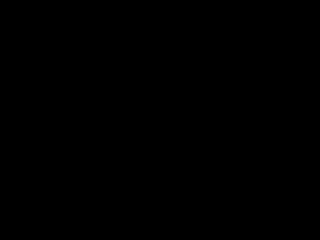

In [5]:
mpath = "mjpc/tasks/go1/go1.xml"
# mpath = "mjpc/tasks/cartpole/task.xml"
tpath = "mjpc/tasks/go1/task_flat.xml"

# model
model_path = (
        pathlib.Path(os.path.abspath("")).parent.parent.parent.parent
        / f"{tpath}"
    )
model = mujoco.MjModel.from_xml_path(str(model_path))

# data
data = mujoco.MjData(model)

# test data
# [model.site(i).name for i in range(model.nsite)]
# ['torso', 'head', 'imu', 'FR', 'FL', 'HR', 'HL']
# mujoco.mj_kinematics(model, data)
# print('raw access:\n', data.geom_xpos)
# MjData also supports named access:
# print('\nnamed access:\n', data.geom('FL').xpos)

# renderer
renderer = mujoco.Renderer(model) # this throws OpenGL error for me
media.show_image(renderer.render())

In [8]:
agent = agent_lib.Agent(task_id="Go1 Flat", model=model)
agent.set_mode("Walk")

/home/wxie/miniconda3/lib/python3.11/site-packages/mujoco_mpc-0.1.0-py3.11-linux-x86_64.egg/mujoco_mpc/mjpc/agent_server: symbol lookup error: /home/wxie/miniconda3/lib/python3.11/site-packages/mujoco_mpc-0.1.0-py3.11-linux-x86_64.egg/mujoco_mpc/mjpc/agent_server: undefined symbol: deflate


FutureTimeoutError: 

# The remaining code has not been altered from cartpole.py

In [ ]:
# rollout horizon
T = 1500

# trajectories
qpos = np.zeros((model.nq, T))
qvel = np.zeros((model.nv, T))
ctrl = np.zeros((model.nu, T - 1))
time = np.zeros(T)

# costs
cost_total = np.zeros(T - 1)
cost_terms = np.zeros((len(agent.get_cost_term_values()), T - 1))

# rollout
mujoco.mj_resetData(model, data)

# cache initial state
qpos[:, 0] = data.qpos
qvel[:, 0] = data.qvel
time[0] = data.time

# frames
frames = []
FPS = 1.0 / model.opt.timestep

# simulate
for t in range(T - 1):
  if t % 100 == 0:
    print("t = ", t)

  # set planner state
  agent.set_state(
      time=data.time,
      qpos=data.qpos,
      qvel=data.qvel,
      act=data.act,
      mocap_pos=data.mocap_pos,
      mocap_quat=data.mocap_quat,
      userdata=data.userdata,
  )

  # run planner for num_steps
  num_steps = 10
  for _ in range(num_steps):
    agent.planner_step()

  # get costs
  cost_total[t] = agent.get_total_cost()
  for i, c in enumerate(agent.get_cost_term_values().items()):
    cost_terms[i, t] = c[1]

  # set ctrl from agent policy
  data.ctrl = agent.get_action()
  ctrl[:, t] = data.ctrl

  # step
  mujoco.mj_step(model, data)

  # cache
  qpos[:, t + 1] = data.qpos
  qvel[:, t + 1] = data.qvel
  time[t + 1] = data.time

  # render and save frames
  renderer.update_scene(data)
  pixels = renderer.render()
  frames.append(pixels)

# reset
agent.reset()

# display video
SLOWDOWN = 0.5
media.show_video(frames, fps=SLOWDOWN * FPS)


In [ ]:
# plot position
fig = plt.figure()

plt.plot(time, qpos[0, :], label="q0", color="blue")
plt.plot(time, qpos[1, :], label="q1", color="orange")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Configuration")

In [ ]:
# plot velocity
fig = plt.figure()

plt.plot(time, qvel[0, :], label="v0", color="blue")
plt.plot(time, qvel[1, :], label="v1", color="orange")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity")

In [ ]:
# plot control
fig = plt.figure()

plt.plot(time[:-1], ctrl[0, :], color="blue")

plt.xlabel("Time (s)")
plt.ylabel("Control")


In [ ]:
# plot costs
fig = plt.figure()

for i, c in enumerate(agent.get_cost_term_values().items()):
  plt.plot(time[:-1], cost_terms[i, :], label=c[0])

plt.plot(time[:-1], cost_total, label="Total (weighted)", color="black")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Costs")
